# Redes neuronales 5

Visión

### Aproximación por suma de diferencias al cuadrado




## Capas convolutivas

Las capas de red que hemos visto hasta ahora se denominan *fully connected (fc)* o **totalmente conectadas**. Esto significa que todas las salidas de una capa anterior están conectadas a todas y cada una de las entradas de la capa siguiente. Por ejemplo, si hubiera 25 neuronas en la capa anterior, cada neurona de la capa siguiente tendría 25 entradas (y una más para el *bias*). En las **capas convolutivas** esto ya no es así. Cada neurona de una capa convolutiva está conectada solo a un conjunto de salidas de la capa anterior. Además, las capas convolutivas esperan una disposición bidimensional de las entradas, no lineal. La figura muestra una neurona (esfera azul) con nueve entradas conectada a un grupo local de nueve valores. El cubo azul representa su salida.

<img src="imgs/NeuronaConv.jpg" width="50%">


Cada neurona de una capa convolutiva comparte en mismo conjunto de pesos, por lo que se podría decir que las neuronas de la capa convolutiva se replican de forma matricial a lo largo y ancho de la entrada. En la figura siguiente vemos la conexión de todas las neuronas de la capa convolutiva.

<img src="imgs/CapaCompleta.jpg" width="40%">

Vamos a echar cuentas, fíjate que hay $15\times10 = 150$ entradas distintas, cada neurona tiene un **campo receptivo** de $3\times3=9$ entradas. Si las alineamos a lo largo y ancho de las entradas tenemos que hay $13\times8=104$ neuronas. ¿Cuántos pesos distintos hay? ¿$104\times9$? ¡¡Nooo!! Solo $9$. Cada neurona comparte el mismo conjunto de pesos, aunque los valores de las entradas son, obviamente, distintos.



Dimensiones de la imagen: (32, 32)
Máximo valor: 1.0
Mínimo valor: 0.0


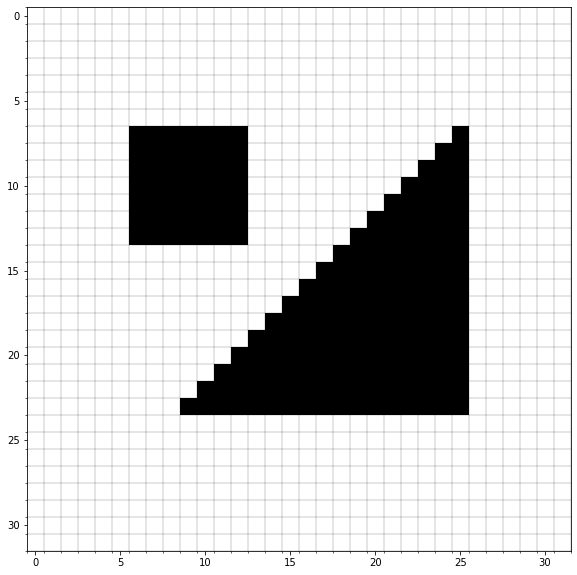

In [109]:
import matplotlib.pyplot as plt
from skimage import io

%matplotlib inline

plt.rcParams['image.cmap'] = 'gray'
image=io.imread("imgs/figuras.png")/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

print("Dimensiones de la imagen:", image.shape)
print("Máximo valor:", image.max())
print("Mínimo valor:", image.min())

plt.figure(figsize=(20,10))
plt.imshow(image)

ax = plt.gca();
ax.set_xticks(np.arange(-.5, 32, 1), minor=True);
ax.set_yticks(np.arange(-.5, 32, 1), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)

Dimensiones de la imagen: (32, 32)
Máximo valor: 3.0
Mínimo valor: -3.0


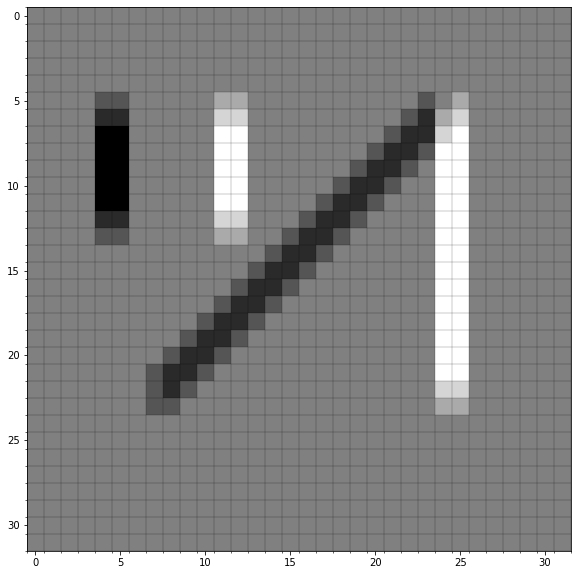

In [112]:
import numpy as np

# Pesos de la neurona
weights = np.array([[-1., 0., 1.],[-1., 0., 1.],[-1., 0., 1.]]) # Detector de bordes verticales
#weights = np.array([[-1., -1., -1.],[0., 0., 0.],[1., 1., 1.]]) # Detector de bordes horizontales
#weights = np.array([[-2., -1., 0.],[-1., 0., 1.],[0., 1., 2.]]) # Detector de bordes diagonales


# Convolución
def convolution(image, kernel):
    result = np.zeros((image.shape[0],image.shape[1]), dtype=float)
    
    for j in range(0, image.shape[0]-2):
        for i in range(0, image.shape[1]-2):
            aux = 0
            for m in range(0, weights.shape[0]):
                for n in range(0, weights.shape[1]):
                    aux += image[j+m][i+n] * weights[m][n] 
            result[j][i] = aux
    return result

image_result = convolution(image, weights)

print("Dimensiones de la imagen:", image_result.shape)
print("Máximo valor:", image_result.max())
print("Mínimo valor:", image_result.min())

plt.figure(figsize=(20,10))
plt.imshow(image_result, vmin=-1,vmax=1)

ax = plt.gca();
ax.set_xticks(np.arange(-.5, 32, 1), minor=True);
ax.set_yticks(np.arange(-.5, 32, 1), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)

plt.imshow(image_result)

Podemos hacer un detector de bordes horizontales, verticales, diagonales, detectores de esquinas, puntos, etc. en función del **kernel** que definamos. Y, además, los podríamos ‘empaquetar’ todos.